In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scipy.signal as signal
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Data preprocessing and cleaning

In [3]:
# Collect the necessary data 
# Note: sampling rate of earbuds is 100Hz
# Note: P02-P06 are missing on left earbuds

# For some subjects device is restarted during experiement causing time series to be inconsistent
# There  6 subjects with right earbud who had only 1 or 0 restarts during trial: P06, P08, P10, P13, P14, P17
# For now energy expenditure research can focus on these subjects since data after restart can be discarded if necessary

pd.options.mode.copy_on_write = True

def rescale_timestamps(df, subject):
    """
    Helper function for ignoring (for now) restarted samples
    and rescale timestamps with special case of min-max normalisation

    x' = x-min(x)
    """

    restart_indices = []
    
    # Find restart points
    restart_mask = df['timestamp'].shift() > df['timestamp']
    restart_indices = restart_mask.index[restart_mask].to_list()

    if restart_indices:
        # Pick only the first restart point. This is intentional (for now) 
        # only subjects with more than 1 restart points are ignored
        df = df.loc[restart_indices[0]:]
        #display(subject)        
        #display(df)

    df["timestamp"] = df["timestamp"] - min(df["timestamp"])
        
    
    #ind_min = np.argmin(df["timestamp"])
    #display(df["timestamp"].loc[ind_min:ind_min+10])
    #print(restart_indices)
    return df

def clean_timestamps(df, subject):

    # Remove non-numeric entries
    df_timestamps = pd.to_numeric(df["timestamp"], errors="coerce")
    nulls = pd.isnull(df_timestamps)
    df["timestamp"] = df_timestamps
    df = df[~nulls]

    # Change dtype to int64 and rescale time stamps to start from 0
    df["timestamp"] = df["timestamp"].to_numpy(dtype=np.int64)
    df = rescale_timestamps(df, subject)
    #display(df)
    return df
    
    
root = "original_dataset/dataset"
subject_dirs = sorted([d for d in os.listdir(root) if d.startswith("P")]) # Get only data related to each subject and sort it

dataframes_right = []

indices_left = []
dataframes_left = []

for i, subject in enumerate(subject_dirs):
    earbud_path = f"{root}/{subject}/EARBUDS/"
    
    earbuds_left = [d for d in os.listdir(earbud_path) if d.startswith(f'{subject}-imu-l')]
    earbuds_right = [d for d in os.listdir(earbud_path) if d.startswith(f'{subject}-imu-r')]

    if earbuds_left:
        path = os.path.join(earbud_path, earbuds_left[0])
        df = pd.read_csv(path)
        #df = clean_timestamps(df)

        #print("Left bud")
        #print(df["timestamp"].iloc[-1] - df["timestamp"].iloc[0])

        dataframes_left.append(df)
        indices_left.append(subject)

    path = os.path.join(earbud_path, earbuds_right[0])
    df = pd.read_csv(path)
    df = clean_timestamps(df, subject)
    dataframes_right.append(df)


df_subjects_right = pd.DataFrame({"Device": ["EARBUD_R"]*len(dataframes_right), "Data": dataframes_right}, index=[subject_dirs])
df_subjects_left = pd.DataFrame({"Device": ["EARBUD_L"]*len(dataframes_left), "Data": dataframes_left}, index=[indices_left])
    
display(df_subjects_right)
display(df_subjects_left)

display(df_subjects_right["Data"].iloc[0])




/tmp/ipykernel_4088/308640382.py:71: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_4088/308640382.py:81: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)
/tmp/ipykernel_4088/308640382.py:81: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,Device,Data
P01,EARBUD_R,timestamp ax ay az gx g...
P02,EARBUD_R,timestamp ax ay az gx gy ...
P03,EARBUD_R,timestamp ax ay az gx ...
P04,EARBUD_R,timestamp ax ay az gx ...
P05,EARBUD_R,timestamp ax ay az gx gy ...
P06,EARBUD_R,timestamp ax ay az gx g...
P07,EARBUD_R,timestamp ax ay az gx g...
P08,EARBUD_R,timestamp ax ay az gx gy ...
P09,EARBUD_R,timestamp ax ay az gx gy ...
P10,EARBUD_R,timestamp ax ay az gx g...


,Device,Data
P01,EARBUD_L,timestamp ax ay a...
P07,EARBUD_L,timestamp ax ay az gx...
P08,EARBUD_L,timestamp ax ay az gx...
P09,EARBUD_L,timestamp ax ay az gx ...
P10,EARBUD_L,timestamp ax ay az gx...
P11,EARBUD_L,timestamp ax ay az gx...
P12,EARBUD_L,timestamp ax ay az gx ...
P13,EARBUD_L,timestamp ax ay az gx ...
P14,EARBUD_L,timestamp ax ay az ...
P15,EARBUD_L,timestamp ax ay az gx ...


,timestamp,ax,ay,az,gx,gy,gz
31,0,16051,867,2510,-574,694,964
32,9,16127,875,2471,-411,753,1016
33,19,16208,895,2431,-248,720,1163
34,28,16286,945,2398,-103,643,1327
35,38,16316,987,2367,18,617,1410
...,...,...,...,...,...,...,...
222015,2131046,3292,15187,4645,-75,67,60
222016,2131056,3326,15226,4632,-82,70,38
222017,2131065,3363,15260,4629,-85,97,30
222018,2131075,3384,15290,4667,-77,134,36


# Visualize

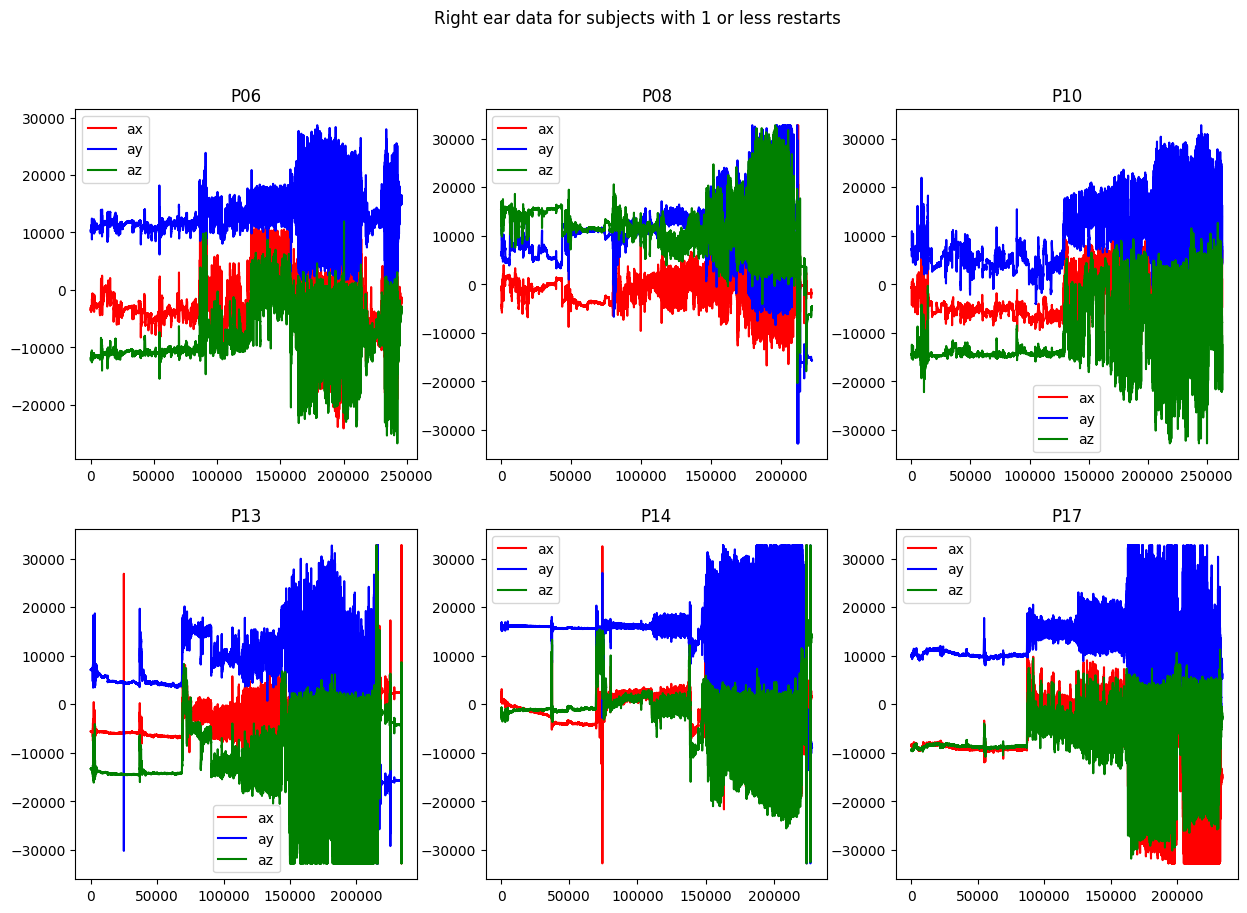

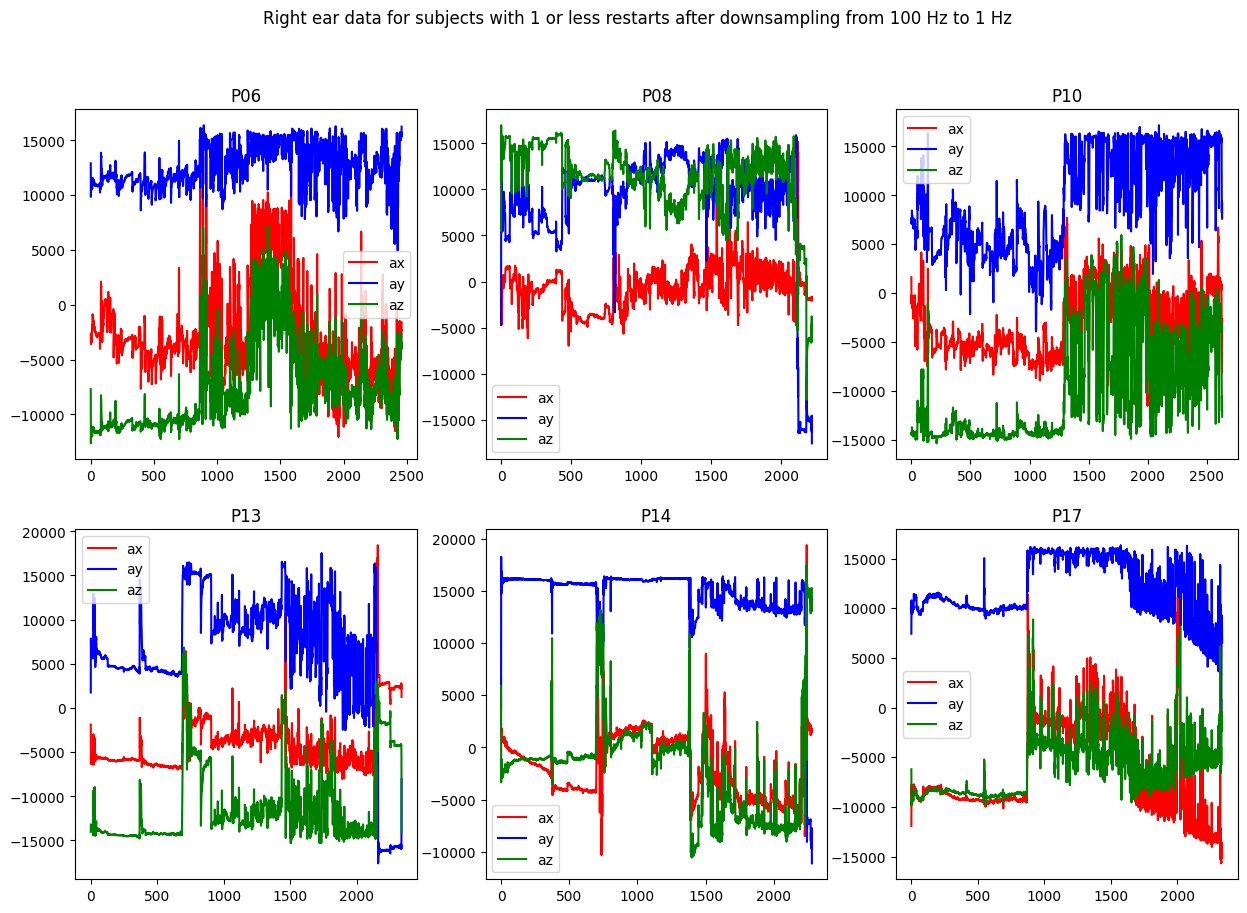

In [54]:
# Visualize the data

# Pick 6 subjects who had only 1 or 0 restarts during trial

SAMPLE_RATE = 100 # Hz
DOWNSAMPLED_RATE = 1 # Hz
WINDOW_SIZE = 30 #  time (s) * sampling_frequency (Hz)


def plot_all(df, processing_func=None, title=""):
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    ax = ax.ravel()

    for i, row in enumerate(df.iterrows()):
        data = row[1].iloc[1]

        if processing_func is not None:
            data = processing_func(data)

        x = np.arange(0, len(data))
        ax_ = data["ax"]
        ay = data["ay"]
        az = data["az"]

        ax[i].plot(x, ax_, "r", label="ax")
        ax[i].plot(x, ay, "b", label="ay")
        ax[i].plot(x, az, "g", label="az")
        ax[i].set_title(df.index[i][0])
        ax[i].legend()
    
    fig.suptitle(title)
    plt.show()

def downsample(data):
    ratio = SAMPLE_RATE / DOWNSAMPLED_RATE
    data_resampled = signal.resample(data, int(math.ceil(len(data) / ratio)))
    timestamp_resampled = data["timestamp"].iloc[::int(ratio)]
    data_resampled[:, 0] = timestamp_resampled
    data = pd.DataFrame(columns=data.columns, data=data_resampled)
    return data

def rolling_win(data, win_size=30):

    # Centered rolling average
    data["ax"] = data["ax"].rolling(window=win_size, center=True, min_periods=win_size).mean()
    data["ay"] = data["ay"].rolling(window=win_size, center=True, min_periods=win_size).mean()
    data["az"] = data["az"].rolling(window=win_size, center=True, min_periods=win_size).mean()

    return data

def downsample_and_roll(data):
    data = downsample(data)
    return rolling_win(data)

subjects = ["P06", "P08", "P10", "P13", "P14", "P17"]
right_ear_subs = df_subjects_right.loc[subjects]


# Raw data no preprocessing
plot_all(right_ear_subs, title="Right ear data for subjects with 1 or less restarts")

# Raw data after downsampling from 100hz to 1hz
plot_all(right_ear_subs, processing_func=downsample, title="Right ear data for subjects with 1 or less restarts after downsampling from 100 Hz to 1 Hz")

# Filtered data with rolling no downsampling 
#plot_all(right_ear_subs, processing_func=rolling_win, title="Right ear data for subjects with 1 or less restarts with rolling average and no downsampling (Winsize = time * sampling rate)")

# Filtered data with rolling window with downsampling and normalisation 
#plot_all(right_ear_subs, processing_func=downsample_and_roll, title="Right ear data for subjects with 1 or less restarts with rolling average and downsampling (Winsize = time * sampling rate)")

(('P06',),
 Device                                             EARBUD_R
 Data              timestamp    ax     ay     az   gx   g...
 Name: (P06,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-2627.617457,12909.541222,-7683.901237,-46.638221,160.724099,-81.580645
1,960.0,-3497.532091,9845.455528,-12633.229957,-46.478767,-113.326518,-16.064266
2,1920.0,-3585.150264,10624.574982,-11318.951222,-2.728953,-5.261031,58.567627
3,2880.0,-3302.863110,10421.168498,-11941.015359,-72.349508,-23.555821,60.947411
4,3840.0,-3207.833564,10905.998082,-11267.500086,-16.449599,-44.240685,103.434803
...,...,...,...,...,...,...,...
2455,2356800.0,-3359.605173,15442.981596,-3770.402951,-112.487348,-113.781950,71.884821
2456,2357760.0,-2911.190080,15337.118845,-3985.297951,60.230183,-193.397795,266.447392
2457,2358720.0,-2268.573181,15752.700512,-3461.674063,-16.638958,-141.471816,30.195812
2458,2359680.0,-2409.064492,15306.372770,-4039.947825,-24.566370,-58.558080,131.379798


(('P08',),
 Device                                             EARBUD_R
 Data              timestamp    ax     ay     az  gx  gy ...
 Name: (P08,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-1098.189128,-4725.070673,5500.012666,21.977062,-10.487918,101.859050
1,960.0,-932.622675,8105.086477,16970.997421,42.507810,-39.529710,-251.729708
2,1920.0,-719.425577,5354.780102,14191.425907,25.367505,-85.314728,202.218502
3,2880.0,-1169.264624,7142.453735,15684.937537,68.655381,215.105482,-517.742698
4,3840.0,-3789.682780,7080.165077,13569.674231,713.849884,473.512243,51.155734
...,...,...,...,...,...,...,...
2215,2126400.0,-1927.707898,-15768.528014,-5998.600709,143.103388,-29.915898,-33.408900
2216,2127360.0,-1681.339520,-14940.773060,-4644.431293,41.329097,-10.350548,70.943605
2217,2128320.0,-1960.739487,-16267.665265,-5628.492027,34.615878,-43.205233,-41.779069
2218,2129280.0,-1643.069260,-14560.316861,-3783.633031,17.561025,-4.734436,85.132078


(('P10',),
 Device                                             EARBUD_R
 Data              timestamp    ax    ay     az    gx   g...
 Name: (P10,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,1616.766980,7648.140955,-14343.584124,-167.721243,-2.975029,854.999781
1,960.0,-1129.393461,7138.766310,-14464.253433,8.336615,-174.265282,172.124554
2,1920.0,-229.046682,7279.612833,-14387.877776,-35.143081,278.627017,-492.472602
3,2880.0,-815.796227,7080.691681,-14523.543509,64.032133,-528.749092,825.981383
4,3840.0,-969.504580,7861.245804,-14016.461783,-472.540949,1889.206127,-3390.862571
...,...,...,...,...,...,...,...
2626,2520960.0,-3827.250793,10519.292303,-11182.397902,1649.042455,-549.640832,-47.844715
2627,2521920.0,-6681.190958,8214.924312,-12085.360032,-1451.979705,917.558239,-2128.689230
2628,2522880.0,-7874.089188,9375.112297,-10546.077602,135.406839,195.080903,-47.053624
2629,2523840.0,-8114.034267,7580.894152,-11981.808064,1011.532030,-604.312795,1187.050626


(('P13',),
 Device                                             EARBUD_R
 Data              timestamp     ax    ay     az     gx  ...
 Name: (P13,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-1880.898286,1744.099378,-14024.743931,206.470804,1550.721625,13.902219
1,960.0,-6331.849969,7871.279136,-13170.830765,-335.555540,-232.500532,-68.018322
2,1920.0,-5193.991088,6751.128333,-13430.909486,215.840629,113.201068,104.289329
3,2880.0,-5916.867659,7395.489303,-13252.634200,-207.685533,-119.535164,-49.780724
4,3840.0,-5438.111437,7145.033610,-13264.687744,148.704948,34.012492,109.532181
...,...,...,...,...,...,...,...
2335,2241600.0,2579.260709,-15911.090738,-4309.006747,231.377053,104.730023,-75.073891
2336,2242560.0,2131.438649,-15450.782439,-4121.295960,-321.897341,-191.473344,120.920211
2337,2243520.0,2807.050825,-15971.459170,-4354.298155,425.744016,250.409986,-150.511324
2338,2244480.0,1699.722957,-14795.789402,-5357.460626,-1613.098830,-1165.800654,206.099888


(('P14',),
 Device                                             EARBUD_R
 Data              timestamp    ax     ay     az   gx   g...
 Name: (P14,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,1315.221623,3671.873396,5885.647528,-116.188710,12.967746,91.975931
1,960.0,1615.341372,18251.658402,-3360.584641,166.949569,-93.059810,-32.462629
2,1920.0,1442.338383,14709.819637,-1466.128072,-117.426528,116.014959,95.126251
3,2880.0,1852.756329,16886.130590,-1924.370881,-71.892299,44.159988,-21.039221
4,3840.0,1509.069036,15384.165707,-1137.038012,86.263877,-188.291580,-2.013540
...,...,...,...,...,...,...,...
2275,2184000.0,1822.976745,-9154.105498,14344.525322,61.498416,-66.615452,-45.722760
2276,2184960.0,1392.470699,-8325.495678,13373.151907,-132.726555,-17.062028,151.131974
2277,2185920.0,1708.748596,-9697.178412,14385.480913,129.306264,-42.177501,-99.458834
2278,2186880.0,1415.618944,-7718.535333,13043.088920,-105.328897,-20.732859,114.581531


(('P17',),
 Device                                             EARBUD_R
 Data              timestamp     ax     ay    az    gx   ...
 Name: (P17,), dtype: object)

,timestamp,ax,ay,az,gx,gy,gz
0,0.0,-11923.401177,7432.446899,-6216.180478,955.466333,-340.658674,450.186276
1,960.0,-7754.751467,10786.152897,-9861.498109,-289.927438,119.731568,-165.126498
2,1920.0,-8999.023802,9460.448244,-9252.075017,194.175443,-122.582237,157.212209
3,2880.0,-8196.605430,10479.766168,-9446.266046,-144.246513,27.525770,-86.173064
4,3840.0,-8784.382865,9761.434411,-9274.026291,85.857637,-48.082888,135.981547
...,...,...,...,...,...,...,...
2335,2241610.0,-13584.538818,9307.965502,-409.159176,21.200880,38.584878,-447.730900
2336,2242570.0,-14047.693641,7805.120971,-1965.302459,-139.703248,150.409654,181.741775
2337,2243530.0,-13837.372074,8732.285514,-1165.056982,394.268014,-235.699519,-8.960060
2338,2244490.0,-13838.241045,8051.609508,-2322.091406,-1097.853395,680.519482,-266.022323


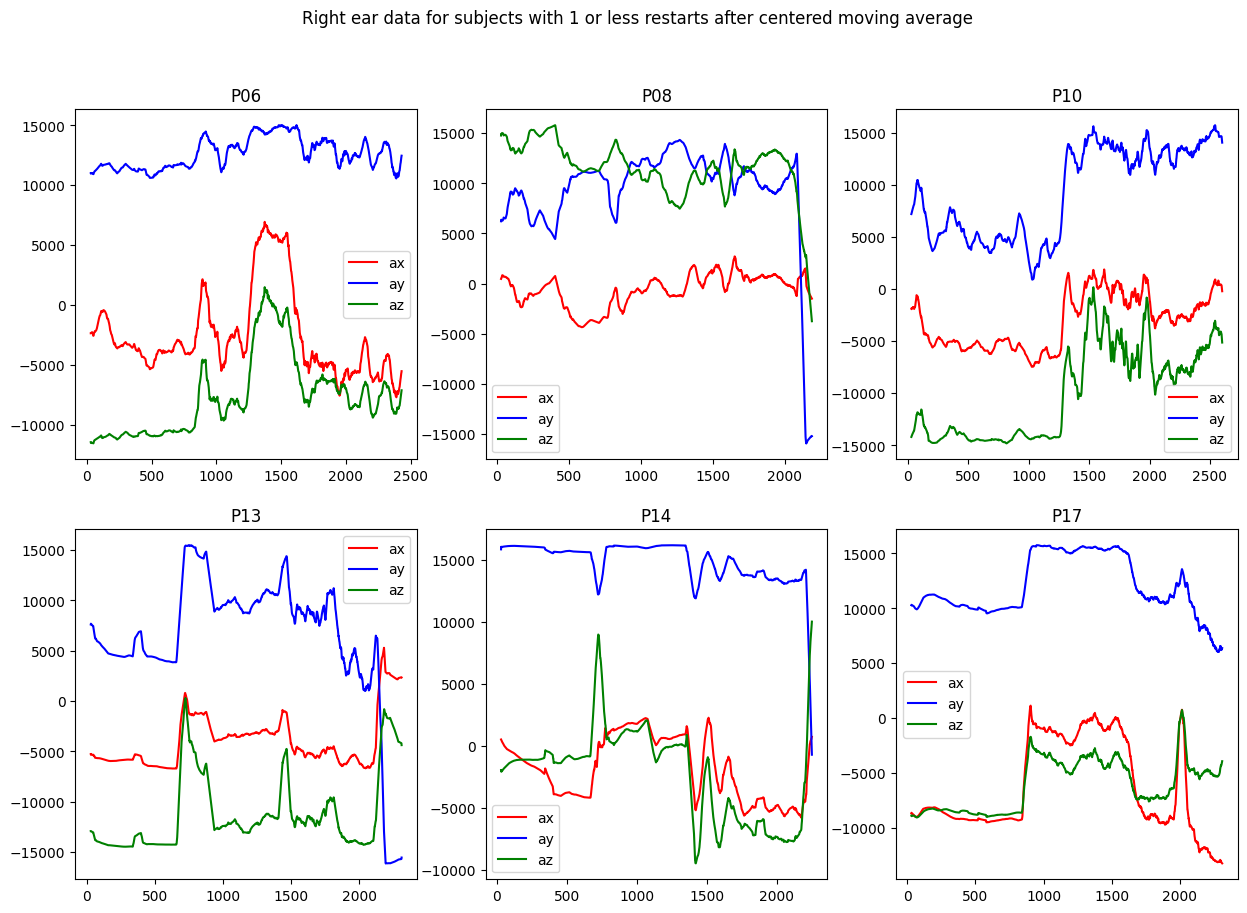

In [6]:
# IGNORE THIS CELL SIMILAR THING IS DONE BELLOW Preprocessing from Amarasinghe et al [1]

# centred moving average

#N_ORDER = 3 # For butterworth
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for i, row in enumerate(right_ear_subs.iterrows()):
    data = row[1].iloc[1]
    #display(row)
    data = downsample(data)
    #data[["ax", "ay", "az"]] = StandardScaler().fit_transform(data[["ax", "ay", "az"]])
    display(data)
    data = rolling_win(data)

    ax_ = data["ax"]
    ay = data["ay"]
    az = data["az"]

    #display(data)
    #ax_ = data["ax"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()
    #ay = data["ay"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()
    #az = data["az"].rolling(window=WINDOW_SIZE, center=True, min_periods=WINDOW_SIZE).mean()


    #display(ax_)
    #display(ay)
    #display(az)

    x = np.arange(0, len(ax_))

    # Discard the first and the last window 
    ax[i].plot(x, ax_, "r", label="ax")
    ax[i].plot(x, ay, "b", label="ay")
    ax[i].plot(x, az, "g", label="az")
    ax[i].set_title(right_ear_subs.index[i][0])
    ax[i].legend()

fig.suptitle("Right ear data for subjects with 1 or less restarts after centered moving average")
#plt.savefig("clean.svg")
plt.show()




# Collecting, visualizing and merging of VO2 data

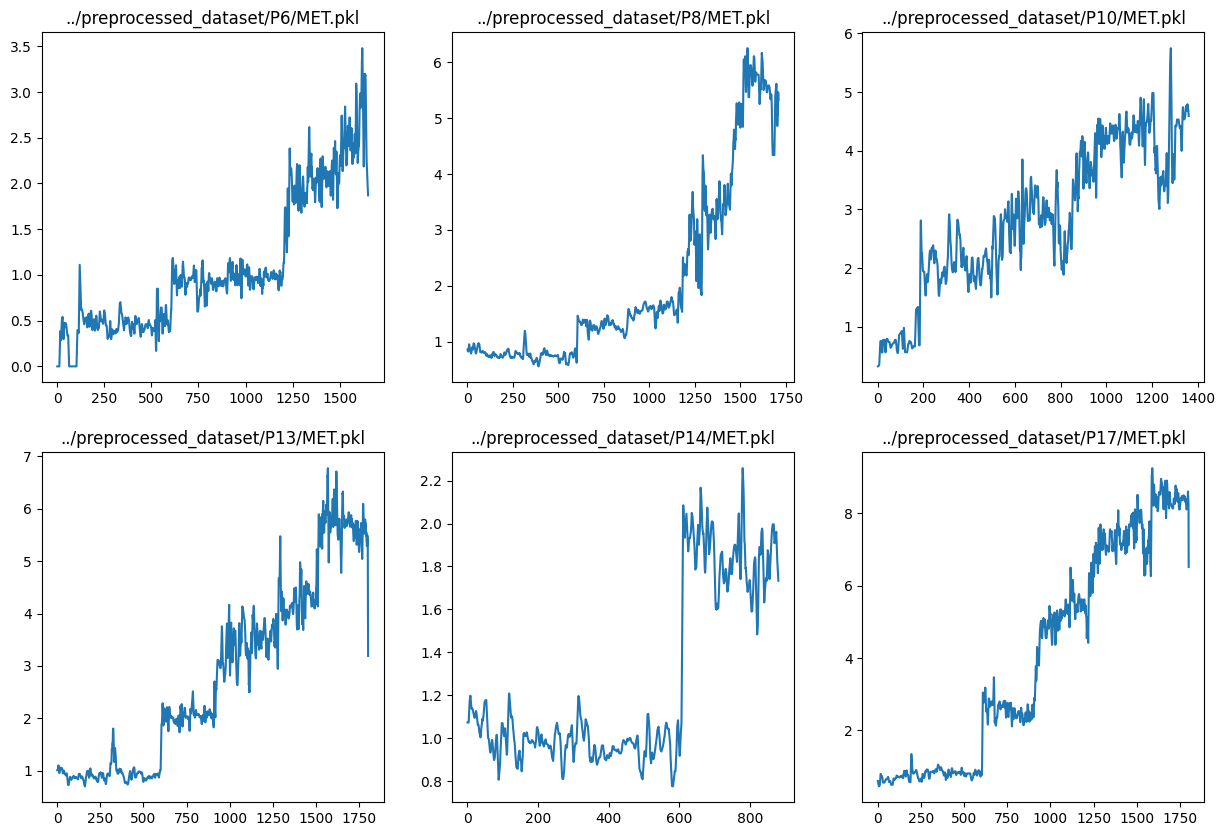

In [51]:
import os
import pickle



dirs = os.listdir("../preprocessed_dataset/")
dirs.remove("demographics.pkl")

dirs = sorted(dirs, key=lambda s: int(s.split("P")[1])) # Hacky way to sort by number in file name

data_wanted = ["P6", "P8", "P10", "P13", "P14", "P17"]
paths = [os.path.join(f"../preprocessed_dataset/{i}/", "MET.pkl") for i in dirs]
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()
index = 0

met_data = {}

for i, path in enumerate(paths):

    name = path.split("/")[2]
    if name in data_wanted:
        with open(path, "rb") as fp:
            data = pickle.load(fp)
            x = data["Time[s]"]
            y = data["MET"]

            ax[index].plot(x, y)
            ax[index].set_title(path)
            index += 1

            met_data[name] = data
            #display(path)
            #display(data)
            

plt.show()

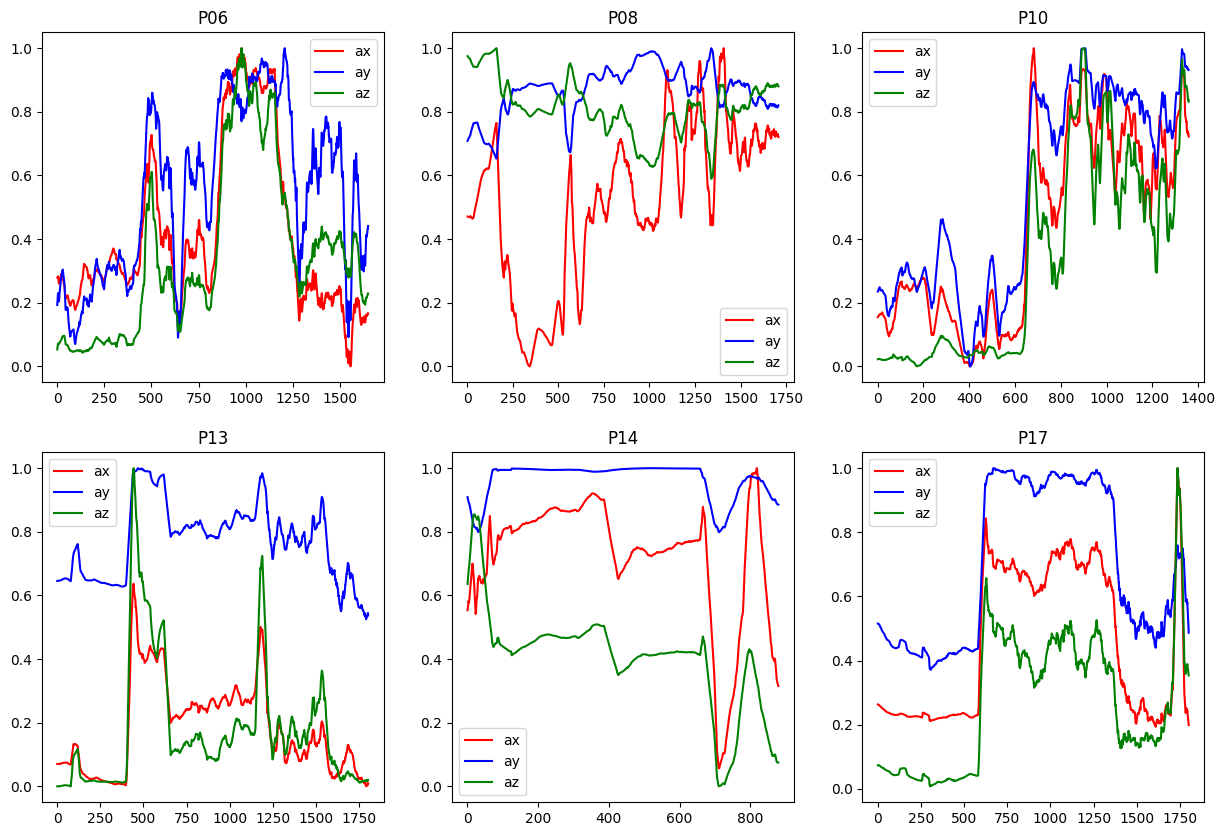

In [61]:
import pickle
from sklearn.preprocessing import MinMaxScaler

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

met_values = list(met_data.values())

def normalize(data, targets: list):
    scaler = MinMaxScaler()
    data[targets] = scaler.fit_transform(data[targets].to_numpy())

    return data


for i, row in enumerate(right_ear_subs.iterrows()):
    data = row[1].iloc[1]
    data = downsample(data)
    data["timestamp"] = (data["timestamp"] / 1000).round()
    data = rolling_win(data, win_size=40).dropna()
    data = normalize(data, targets=["ax", "ay", "az"])

    len_diff = len(data) - len(met_values[i])
    #data = data[len_diff // 2: len(met_values[i]) + (len_diff//2)]

    #data.rename(columns={"timestamp": "Time[s]"}, inplace=True)
    #data = data.reset_index(drop=True)
    #display(met_values[i]["Time[s]"])
    
    
    #data["Time[s]"] = met_values[i]["Time[s]"].reset_index(drop=True)
    #data[["Delta_Time", "MET", "Activity"]] = met_values[i][["Delta_Time", "MET", "Activity"]].reset_index(drop=True)

    ax_ = data["ax"]
    ay = data["ay"]
    az = data["az"]
    
    x = np.arange(0, len(ax_))

    ax[i].plot(x[1:], ax_[1:], "r", label="ax")
    ax[i].plot(x[1:], ay[1:], "b", label="ay")
    ax[i].plot(x[1:], az[1:], "g", label="az")
    ax[i].set_title(right_ear_subs.index[i][0])
    ax[i].legend()


    #print(right_ear_subs.index[i][0]) 
    #display(data)

    #with open(f"merged/{right_ear_subs.index[i][0]}.pkl", "wb") as fp:
    #    pickle.dump(data, fp)
        

# Training model

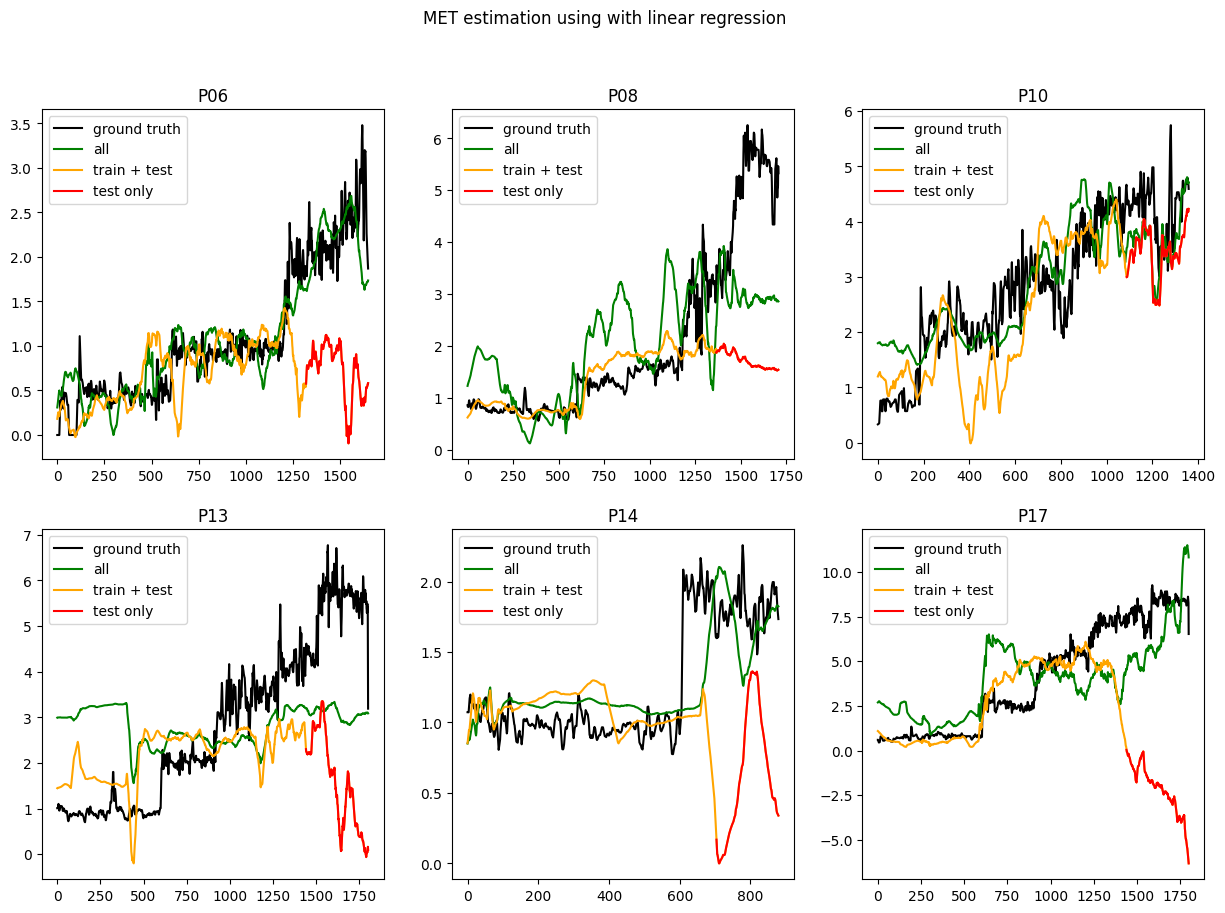

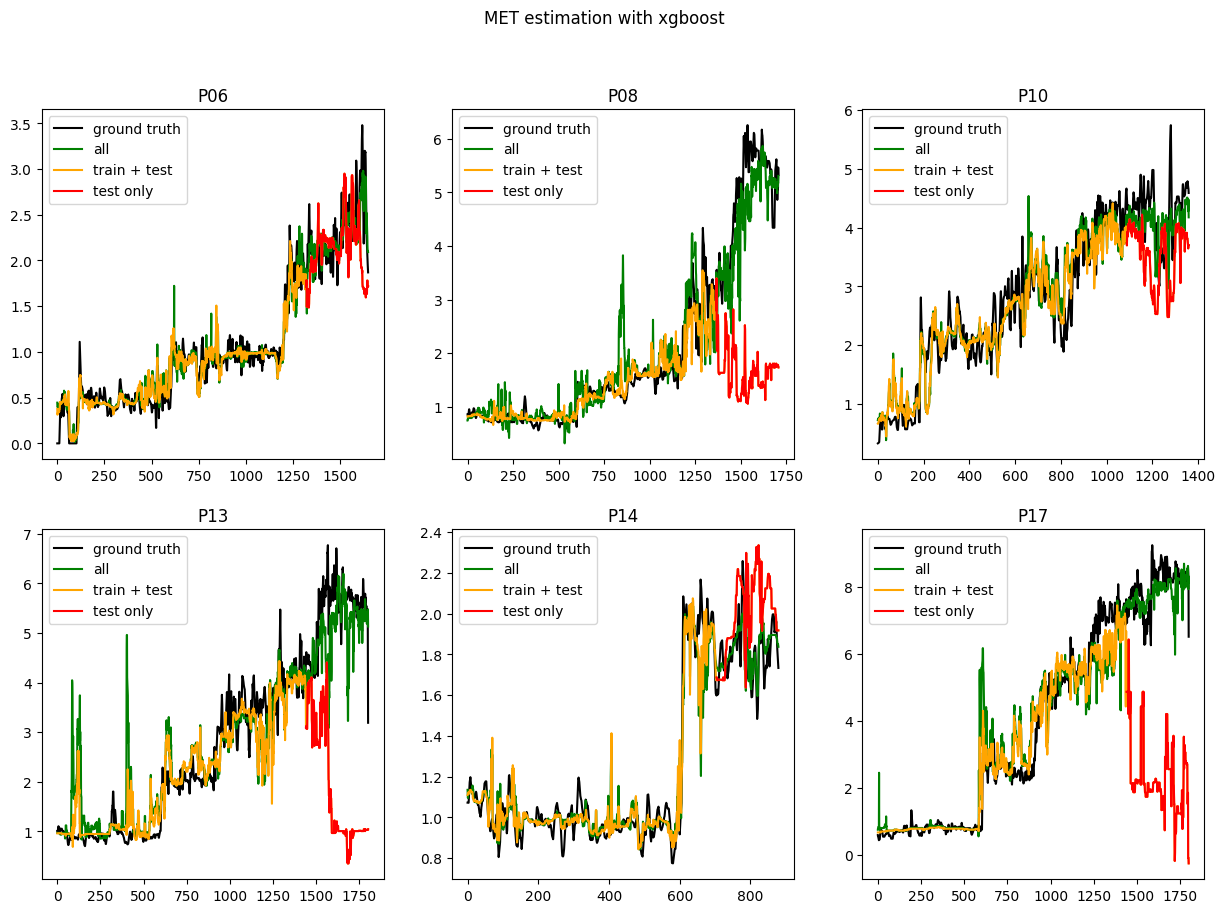

,MAE_ALL,MAE_train_test,MAE_test,MSE_ALL,MSE_train_test,MSE_test
P06,0.231979,0.551266,1.572397,0.104535,0.72064,2.797229
P08,0.984489,0.913158,3.189952,1.674667,2.466309,11.31236
P10,0.589597,0.796808,0.820264,0.524825,0.899877,0.928096
P13,1.473948,1.486511,3.865243,2.86728,4.180657,16.659861
P14,0.220835,0.442915,1.172696,0.092214,0.453243,1.606906
P17,1.80252,2.881308,10.192777,4.431723,23.601876,106.892772


,MAE_ALL,MAE_train_test,MAE_test,MSE_ALL,MSE_train_test,MSE_test
P06,0.116269,0.140277,0.329379,0.027376,0.059643,0.231357
P08,0.316511,0.777133,3.273697,0.24939,2.459669,12.046514
P10,0.324481,0.388767,0.791725,0.174704,0.299138,0.943544
P13,0.441872,0.960222,3.558143,0.455264,3.206385,15.217979
P14,0.070482,0.093219,0.219501,0.012274,0.023848,0.079553
P17,0.467415,1.436556,5.707366,0.599661,7.189128,34.520022


In [56]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

paths = sorted([f"merged/{i}" for i in os.listdir("merged/")])

parameters_4_50 = dict([('colsample_bytree', 0.6174372236293935),
             ('learning_rate', 0.03335590817699578),
             ('max_depth', 3),
             ('min_child_weight', 2.8157820836606042),
             ('subsample', 0.5)])

parameters_17_100 = dict([('colsample_bytree', 0.6771669106036801),
             ('learning_rate', 0.044101899680420484),
             ('max_depth', 3),
             ('min_child_weight', 0.5),
             ('subsample', 0.3)])

parameters_17_50 = dict([('colsample_bytree', 0.8293768713559813),
             ('learning_rate', 0.07734816836241316),
             ('max_depth', 3),
             ('min_child_weight', 0.5),
             ('subsample', 0.3)])

params = parameters_17_50

def train_and_predict(data, model="linear_regression", plot_ax=None):
    X = data[["ax", "ay", "az"]]
    y = data["MET"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    if model == "linear_regression":
        model = LinearRegression(fit_intercept=False)
        model.fit(X_train, y_train)
        preds_train_test = model.predict(X)
        preds_test = model.predict(X_test)
        
        model = LinearRegression()
        model.fit(X, y)
        preds_all = model.predict(X)

    elif model == "xgboost":
        model = XGBRegressor(random_state=42, **params)
        model.fit(X_train, y_train)
        preds_train_test = model.predict(X)
        preds_test = model.predict(X_test)
        
        model = XGBRegressor(random_state=42, **params)
        model.fit(X, y)
        preds_all = model.predict(X)

    if plot_ax:
        
        plot_ax.plot(y, "black", label="ground truth")
        plot_ax.plot(preds_all, "g", label="all")
        plot_ax.plot(preds_train_test, "orange", label="train + test")
        
        x = data["Time[s]"].iloc[len(X_train)-1:-1]
        plot_ax.plot(x, preds_test, "r", label="test only")
        plot_ax.legend()

    mse_all = mean_squared_error(y, preds_all)
    mse_train_test = mean_squared_error(y, preds_train_test)
    mse_test_only = mean_squared_error(y_test, preds_test)
    
    mae_all = mean_absolute_error(y, preds_all)
    mae_train_test = mean_absolute_error(y, preds_train_test)
    mae_test_only = mean_absolute_error(y_test, preds_test)

    metrics = [mae_all, mae_train_test, mae_test_only, mse_all, mse_train_test, mse_test_only] 
    return metrics
        


fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()


subjects = [s.split("/")[1].strip(".pkl") for s in paths]
df_regression = pd.DataFrame(columns=["MAE_ALL", "MAE_train_test", "MAE_test", "MSE_ALL", "MSE_train_test", "MSE_test"], index=subjects)
df_xgboost = pd.DataFrame(columns=["MAE_ALL", "MAE_train_test", "MAE_test", "MSE_ALL", "MSE_train_test", "MSE_test"], index=subjects)

for i, path in enumerate(paths):
    with open(path, "rb") as fp:
        data = pickle.load(fp)
        metrics = train_and_predict(data, model="linear_regression", plot_ax=ax[i])
        df_regression.iloc[i] = metrics
        ax[i].set_title(path.split("/")[1].strip(".pkl"))

fig.suptitle("MET estimation using with linear regression")
plt.show()

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax = ax.ravel()

for i, path in enumerate(paths):
    with open(path, "rb") as fp:
        data = pickle.load(fp)
        metrics = train_and_predict(data, model="xgboost", plot_ax=ax[i])
        df_xgboost.iloc[i] = metrics
        ax[i].set_title(path.split("/")[1].strip(".pkl"))

fig.suptitle("MET estimation with xgboost")
plt.show()

display(df_regression)
display(df_xgboost)



### Refrences

[1] Amarasinghe, Y., Sandaruwan, D., Madusanka, T., Perera, I., & Meegahapola, L. (2023). Multimodal Earable Sensing for Human Energy Expenditure Estimation.